In [53]:
pip install 'accelerate>=0.26.0'


Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'accelerate": Expected package name at the start of dependency specifier
    'accelerate
    ^


In [54]:
# Mempersiapkan Dataset dan Import Library

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score
from peft import LoraModel, LoraConfig


# Membaca dataset
file_path = 'PEMILU2024.xlsx'
df = pd.read_excel(file_path)

# Menampilkan beberapa baris pertama
df.head()


,Date,Sentimen,Username,Kategori
0,Sun Aug 20 23:58:34 +0000 2023,"Komisi Pemilihan Umum, Sabtu (19/8/2023), memp...",hariankompas,netral
1,Sun Aug 20 23:57:12 +0000 2023,"Targetkan Enam Kursi di Pemilu 2024, Ketua DPC...",metrojambi,netral
2,Sun Aug 20 23:56:45 +0000 2023,Presiden 2024 hanya Ganjar PranowoTerbaik !! y...,ganjarist_satu,positif
3,Sun Aug 20 23:56:08 +0000 2023,"kontestasi berharap cawapres"" versus ""kandidat...",irwan_dwi_a,netral
4,Sun Aug 20 23:55:29 +0000 2023,"*Minggu Kasih Kapolres Tabanan, Ajak Jemaat Su...",HKerambitan,netral


In [55]:
# Preprocessing
import re

# Fungsi untuk preprocessing
def clean_text(text):

    text = re.sub(r'http\S+|www\S+', '', text)
    # Menghapus URL

    text = re.sub(r'@\w+', '', text)
    # Menghapus mention

    text = re.sub(r'#\w+', '', text)
    # Menghapus hashtag

    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Menghapus karakter khusus

    text = text.lower()
    # Menjadikan semua huruf menjadi huruf kecil
    return text

# Menerapkan pembersihan pada kolom Tweet
df['Tweet_clean'] = df['Sentimen'].apply(clean_text)

# Menampilkan beberapa baris pertama
print(df[['Sentimen', 'Tweet_clean']].head())


                                            Sentimen  \
0  Komisi Pemilihan Umum, Sabtu (19/8/2023), memp...   
1  Targetkan Enam Kursi di Pemilu 2024, Ketua DPC...   
2  Presiden 2024 hanya Ganjar PranowoTerbaik !! y...   
3  kontestasi berharap cawapres" versus "kandidat...   
4  *Minggu Kasih Kapolres Tabanan, Ajak Jemaat Su...   

                                         Tweet_clean  
0  komisi pemilihan umum sabtu 1982023 memperbaru...  
1  targetkan enam kursi di pemilu 2024 ketua dpc ...  
2  presiden 2024 hanya ganjar pranowoterbaik  yan...  
3  kontestasi berharap cawapres versus kandidat c...  
4  minggu kasih kapolres tabanan ajak jemaat suks...  


In [56]:
label_encoder = LabelEncoder()

# Melakukan encoding pada kolom kategori
df['Kategori_encoded'] = label_encoder.fit_transform(df['Kategori'])

# Menampilkan hasil encoding
df[['Kategori', 'Kategori_encoded']].drop_duplicates()

# Memeriksa kolom yang ada dalam dataframe
print(df.columns)


Index(['Date', 'Sentimen', 'Username', 'Kategori', 'Tweet_clean',
       'Kategori_encoded'],
      dtype='object')


In [57]:
# Pembagian Data ke dalam Training, Validation, dan Test Set

from sklearn.model_selection import train_test_split

# Pembagian data (70% training, 15% validation, 15% testing)
train_data, temp_data = train_test_split(df, test_size=0.3, random_state=42)
valid_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Menampilkan ukuran data untuk memastikan pembagian
print(f'Train Data: {len(train_data)}')
print(f'Validation Data: {len(valid_data)}')
print(f'Test Data: {len(test_data)}')

Train Data: 2429
Validation Data: 521
Test Data: 521


In [58]:
# Memuat model dan tokenizer IndoBERT
model = AutoModelForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p2', num_labels=3)
tokenizer = AutoTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

# Fungsi untuk tokenisasi
def tokenize_text(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')

# Terapkan tokenisasi pada data
train_tokenized = train_data['Tweet_clean'].apply(tokenize_text)
valid_tokenized = valid_data['Tweet_clean'].apply(tokenize_text)
test_tokenized = test_data['Tweet_clean'].apply(tokenize_text)

# Menampilkan hasil tokenisasi untuk beberapa contoh
print(train_tokenized.iloc[0])


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'input_ids': tensor([[    2, 11283,   351,  1647,  6011,    34,  1541,   112,  2255,  7578,
            26,   300,  2852,   219,  9162,  2294,  2813,    90,  2800,  1772,
          8693,     3,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [59]:
# Menambahkan hasil tokenisasi ke DataFrame untuk training, validation, dan testing
train_data['input_ids'] = train_tokenized.apply(lambda x: x['input_ids'].squeeze().tolist())
train_data['attention_mask'] = train_tokenized.apply(lambda x: x['attention_mask'].squeeze().tolist())

valid_data['input_ids'] = valid_tokenized.apply(lambda x: x['input_ids'].squeeze().tolist())
valid_data['attention_mask'] = valid_tokenized.apply(lambda x: x['attention_mask'].squeeze().tolist())

test_data['input_ids'] = test_tokenized.apply(lambda x: x['input_ids'].squeeze().tolist())
test_data['attention_mask'] = test_tokenized.apply(lambda x: x['attention_mask'].squeeze().tolist())

# Menambahkan kolom 'labels' yang berisi kategori encoded
train_data['labels'] = train_data['Kategori_encoded']
valid_data['labels'] = valid_data['Kategori_encoded']
test_data['labels'] = test_data['Kategori_encoded']

# Konversi DataFrame menjadi Dataset untuk Trainer
train_dataset = Dataset.from_pandas(train_data[['input_ids', 'attention_mask', 'labels']])
valid_dataset = Dataset.from_pandas(valid_data[['input_ids', 'attention_mask', 'labels']])
test_dataset = Dataset.from_pandas(test_data[['input_ids', 'attention_mask', 'labels']])

# Menghapus kolom '__index_level_0__' jika ada
columns_to_remove = ['__index_level_0__']
train_dataset = train_dataset.remove_columns([col for col in columns_to_remove if col in train_dataset.column_names])
valid_dataset = valid_dataset.remove_columns([col for col in columns_to_remove if col in valid_dataset.column_names])
test_dataset = test_dataset.remove_columns([col for col in columns_to_remove if col in test_dataset.column_names])

# Memeriksa beberapa contoh untuk memastikan
print(train_dataset[0])


{'input_ids': [2, 11283, 351, 1647, 6011, 34, 1541, 112, 2255, 7578, 26, 300, 2852, 219, 9162, 2294, 2813, 90, 2800, 1772, 8693, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 2}


In [60]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score

# Inisialisasi model dengan 3 kelas (sesuai dengan kategori sentimen)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Setup parameter training

training_args = TrainingArguments(
    output_dir='./results',          
    # direktori hasil output

    num_train_epochs=3,              
    # jumlah epoch

    per_device_train_batch_size=16,  
    # batch size per device pada training

    per_device_eval_batch_size=64,   
    # batch size per device pada evaluasi

    warmup_steps=500,                
    # jumlah warmup steps

    weight_decay=0.01,               
    # decay untuk regularisasi

    logging_dir='./logs',            
    # direktori log

    logging_steps=10,
    eval_strategy="epoch",           
    # evaluasi per epoch

    save_strategy="epoch",           
    # simpan model setiap epoch
    
    report_to='none',                
    # Menonaktifkan W&B logging
)

# Implementasi fungsi untuk menghitung metrik model
def compute_metrics(p):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}

# Inisialisasi Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset, # Use Dataset object
    eval_dataset=valid_dataset,  # Use Dataset object
    compute_metrics=compute_metrics, # Add compute_metrics function
)

# Fine-tune model
trainer.train()

# Evaluasi model pada data validasi
eval_result = trainer.evaluate(valid_dataset)  # Evaluasi model pada data validasi
print(eval_result)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\analisis sentimen pemilu indobert\env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.912400,0.923972,0.612284
2,0.813500,0.798728,0.658349
3,0.655900,0.921311,0.608445


d:\analisis sentimen pemilu indobert\env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\analisis sentimen pemilu indobert\env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\analisis sentimen pemilu indobert\env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.92131108045578, 'eval_accuracy': 0.6084452975047985, 'eval_runtime': 31.656, 'eval_samples_per_second': 16.458, 'eval_steps_per_second': 0.284, 'epoch': 3.0}


In [61]:
# Prediksi pada data test
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)

# Menampilkan precision, recall dan f1-score
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_data['Kategori_encoded'], predicted_labels, target_names=label_encoder.classes_))


d:\analisis sentimen pemilu indobert\env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

     negatif       0.45      0.52      0.48        77
      netral       0.86      0.45      0.59       255
     positif       0.54      0.86      0.67       189

    accuracy                           0.61       521
   macro avg       0.62      0.61      0.58       521
weighted avg       0.69      0.61      0.60       521



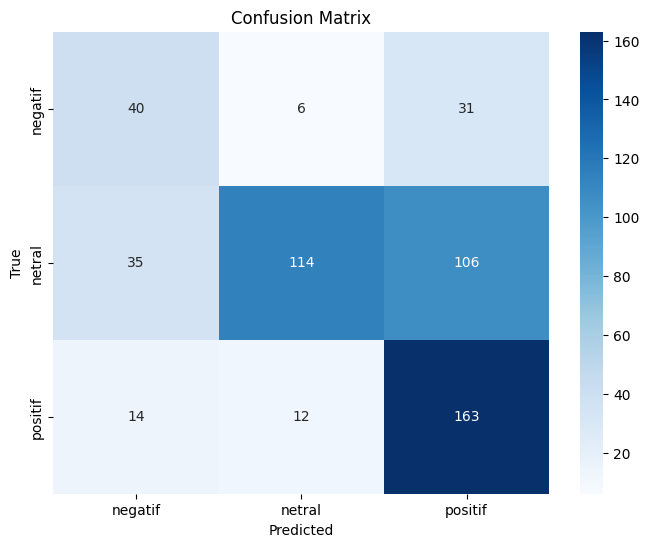

In [62]:
# Visualisasi dengan Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Menghitung confusion matrix
cm = confusion_matrix(test_data['Kategori_encoded'], predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()